# User agent rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
# Number of 'user agents'
n = 10000

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("useragent")
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

useragents = {}
timestamps = {}
counts = {}

all_useragents = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    ua = list(ent["entities"][2].keys())[0]
    
    # Truncate user-agent string
    ua = ua[:30]
    k = (dev, ua)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in useragents:
        useragents[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    useragents[dev].add(ua)
    all_useragents.add(ua)
    all_devices.add(dev)

In [5]:
all_devices = list(all_devices)
all_useragents = list(all_useragents)

## Construct user agent to device matrix

In [6]:
def get_counts(ua, dev):
    if ua in useragents[dev]: return counts[(dev, ua)]
    return 0

datas = [ [ get_counts(ua, dev) for dev in all_devices ] for ua in all_useragents]
df = pd.DataFrame(datas, index=all_useragents, columns=all_devices)
df["score"] = df.sum(axis=1)
df

,dgmac,turing-macbook,calcannea-mac,dramatic-mac,daniel-chromebook,appropriate-android,serotinal-mac,turing-chromebook,traverses-mac,DESKTOP-PIMD8C0,...,rarb-mac,ludicrous-mac,elysium-mac,minesweepers-mac,terrestrial-mac,steamverne-mac,theatergoing-mac,venkata,languid-mac,score
WicaAgent,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,8
Mozilla/5.0 (Macintosh; Intel,2,0,1,23563,0,0,3735,21,7,0,...,98,13,2051,2692,8058,2396,189,2,3030,96624
Mac OS X/10.13.4 (17E202),0,0,0,0,0,0,0,0,2,0,...,0,0,1,0,0,0,0,0,12,25
ACC_2.00.3024_1D9C5725FB718375,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
helperamc/1.5 CFNetwork/897.15,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
Mac OS X/10.13.3 (17D47),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
McHttpH,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,8
gamed/5.10.19.4.8.16.5.4.2 (Ma,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,25
Mozilla/5.0 (Linux; Android 6.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3727
Acrobat%20Updater/1%20.%200%20,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,1,6


## Get list of highest accessed user agents by all devices

In [7]:
top_uas = df.sort_values(by="score", ascending=False).index.values[:n]
top_uas

array(['Mozilla/5.0 (Macintosh; Intel ', 'Roblox/Darwin',
       'Mozilla/5.0 (X11; CrOS x86_64 ', 'Microsoft-Delivery-Optimizatio',
       'Mozilla/5.0 EA Download Manage', 'ProtoHttp 1.3/DS 15.1.2.3.0 (A',
       'python-requests/2.13.0', 'Mozilla/5.0 (X11; Ubuntu; Linu',
       'trustd (unknown version) CFNet', 'Mozilla/5.0 (Linux; Android 6.',
       'Dalvik/2.1.0 (Linux; U; Androi', 'Mozilla/5.0 (Windows NT 10.0; ',
       'Microsoft-WNS/10.0', 'Debian APT-HTTP/1.3 (1.2.26)',
       'MICROSOFT_DEVICE_METADATA_RETR', 'ClamAV/0.100.0 (OS: darwin17.5',
       'Microsoft-CryptoAPI/10.0', 'Spotify/8.4.61 Android/27 (Pix',
       'Mozilla/5.0 (Windows NT 6.1) A', 'Windows-Update-Agent/10.0.1001',
       'Safari/13605.2.8 CFNetwork/901', 'Microsoft BITS/7.8',
       'server-bag [Mac OS X,10.13.5,1', 'dnf/2.7.5',
       'Mozilla/5.0 (Linux; Android 8.', 'Software%20Update (unknown ver',
       'MacAppStore/2.4 (Macintosh; OS', 'Mac OS X/10.12.6 (16G1408)',
       'server-bag [Mac OS X,10.

## Spearman's Rho

In [8]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = max(len(a), len(b))
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = n
        val = val * val
        
        tot += val
        
    for i in range(len(a), len(b)):
        tot += len(b) * len(b)
        
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

## Get favourite user agents by device

In [9]:
fav_uas = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_uas

[['dgmac',
  array(['trustd (unknown version) CFNet', 'Mozilla/5.0 (Macintosh; Intel ',
         'CaptiveNetworkSupport-346.50.1', 'Beyond%20Compare/4020.42.79 CF',
         'Mac OS X/10.12.6 (16G1314)', 'ACC_2.00.3024_11D6185BEBA45BBE',
         'X-Lite/5.2.0.90533 Mozilla/5.0', 'Microsoft Windows Network Diag',
         'mobileassetd (unknown version)', '(null)/(null) (Macintosh; OS X',
         '"Mozilla/5.0 (iPhone; CPU iPho', 'Spotlight/1075.40 CFNetwork/81',
         'dnf/1.1.10', 'Spotify/8.4.61 Android/27 (Pix', 'IPM',
         'Mozilla/4.0 (compatible)', 'Mozilla/5.0 (Linux; Android 8.',
         'Mac OS X/10.13.6 (17G65)', 'Dalvik/2.1.0 (Linux; U; Androi',
         'Mac OS X/10.12.6 (16G1036)', 'ACC_2.00.3024_1C527FCD813E4FC6',
         'Mozilla/5.0 (X11; Linux x86_64', 'Spotify/107700338 (9; 0; 2)',
         'MacAppStore/2.2 (Macintosh; OS', 'Mac OS X/10.13.5 (17F77)',
         'Advanced Mac Cleaner/1.14.5 Sp', 'ACC_2.00.3024_16CE40735E8E8A0C',
         'Roblox/199282 CFNetw

In [10]:
df2 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
df2

,useragents
device,
dgmac,"[trustd (unknown version) CFNet, Mozilla/5.0 (..."
turing-macbook,"[iTunes/12.7.5 (Macintosh; OS X, server-bag [M..."
calcannea-mac,"[Mozilla/5.0 (Linux; Android 8., AndroidDownlo..."
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ..."
daniel-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Dalvik/2.1.0 ..."
appropriate-android,"[Dalvik/2.1.0 (Linux; U; Androi, Spotify/8.4.6..."
serotinal-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
turing-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (..."
traverses-mac,"[trustd (unknown version) CFNet, MacAppStore/2..."


## Compute Spearman co-efficient
against most common domains

In [11]:
df2["coefficient"] = df2["useragents"].apply(lambda x: spearman(x, top_uas)).round(2)

In [12]:
df2.sort_values(by="coefficient", ascending=False)[["useragents", "coefficient"]]

,useragents,coefficient
device,,
theatergoing-mac,"[Mozilla/5.0 (Macintosh; Intel , Microsoft-Del...",0.22
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ...",0.20
steamverne-mac,"[Mozilla/5.0 (X11; Ubuntu; Linu, Mozilla/5.0 (...",0.13
minesweepers-mac,"[Mozilla/5.0 (Macintosh; Intel , ClamAV/0.100....",0.13
misskitty-mac,"[Mozilla/5.0 (Macintosh; Intel , ClamAV/0.100....",0.09
languid-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.08
turing-minimacbook,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.07
simon-macpro,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.06
mark-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.06


## Device to device co-efficient

In [13]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
for dev, uas in everyone:
    df3[dev] = df3["useragents"].apply(lambda x: spearman(uas, x)).round(2)

In [14]:
df3

,useragents,dgmac,turing-macbook,calcannea-mac,dramatic-mac,daniel-chromebook,appropriate-android,serotinal-mac,turing-chromebook,traverses-mac,...,abroad-android,rarb-mac,ludicrous-mac,elysium-mac,minesweepers-mac,terrestrial-mac,steamverne-mac,theatergoing-mac,venkata,languid-mac
device,,,,,,,,,,,,,,,,,,,,,
dgmac,"[trustd (unknown version) CFNet, Mozilla/5.0 (...",1.00,0.82,0.91,0.63,0.92,0.90,0.92,0.92,0.85,...,0.93,0.89,0.92,0.78,0.75,0.88,0.75,0.63,0.86,0.79
turing-macbook,"[iTunes/12.7.5 (Macintosh; OS X, server-bag [M...",0.82,1.00,0.85,0.59,0.85,0.87,0.77,0.85,0.80,...,0.88,0.85,0.89,0.72,0.63,0.84,0.64,0.59,0.81,0.73
calcannea-mac,"[Mozilla/5.0 (Linux; Android 8., AndroidDownlo...",0.91,0.85,1.00,0.62,0.94,0.92,0.87,0.94,0.86,...,0.95,0.90,0.94,0.76,0.70,0.89,0.70,0.64,0.88,0.77
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ...",0.63,0.59,0.62,1.00,0.64,0.64,0.66,0.65,0.71,...,0.66,0.69,0.68,0.71,0.53,0.68,0.55,0.46,0.60,0.72
daniel-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Dalvik/2.1.0 ...",0.92,0.85,0.94,0.64,1.00,0.93,0.86,0.99,0.85,...,0.97,0.90,0.96,0.77,0.71,0.89,0.71,0.65,0.89,0.77
appropriate-android,"[Dalvik/2.1.0 (Linux; U; Androi, Spotify/8.4.6...",0.90,0.87,0.92,0.64,0.93,1.00,0.84,0.92,0.87,...,0.96,0.89,0.93,0.78,0.70,0.87,0.71,0.65,0.87,0.78
serotinal-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.92,0.77,0.87,0.66,0.86,0.84,1.00,0.86,0.86,...,0.87,0.89,0.87,0.79,0.82,0.82,0.81,0.65,0.80,0.80
turing-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",0.92,0.85,0.94,0.65,0.99,0.92,0.86,1.00,0.86,...,0.97,0.90,0.96,0.78,0.71,0.90,0.72,0.65,0.89,0.78
traverses-mac,"[trustd (unknown version) CFNet, MacAppStore/2...",0.85,0.80,0.86,0.71,0.85,0.87,0.86,0.86,1.00,...,0.89,0.91,0.88,0.89,0.72,0.85,0.75,0.68,0.82,0.92


In [15]:
## Don't need to calculate the log.

## Plot heatmap

In [16]:
mask = np.zeros_like(df3[all_devices][all_devices])
mask[np.triu_indices_from(mask)] = True

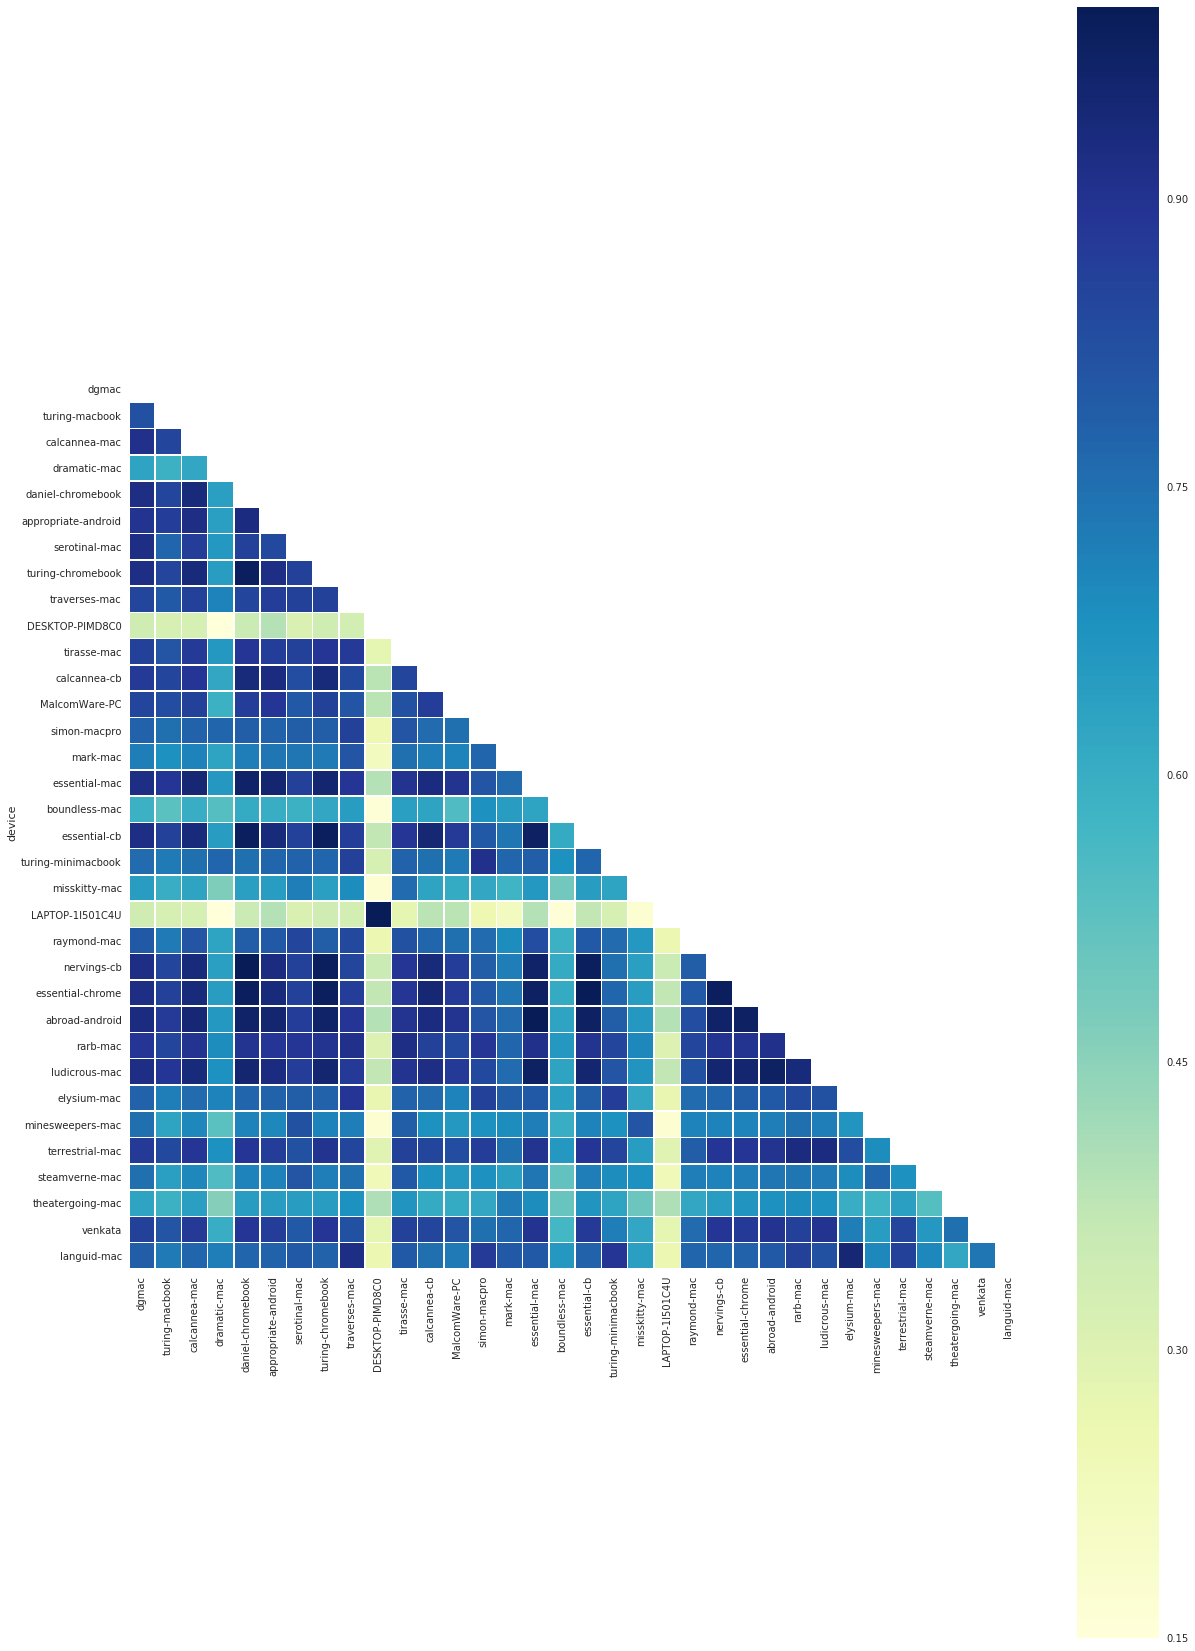

In [17]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()

## Kendall Tau

In [18]:
# Calculate Rho on 2 lists
def correlator(a, b):

    n = max(len(a), len(b))
    
    alst = [v for v in range(0,len(a))]
    amap = {a[i]: i for i in range(0, len(a)) }
    blst = [amap[b[v]] if b[v] in amap else len(a) for v in range(0, len(b))]
    alst.extend([len(a)] * (n - len(a)))
    blst.extend([len(a)] * (n - len(b)))

    tau, p = stats.weightedtau(alst, blst)
  
    return tau

In [19]:
df3 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
for dev, uas in everyone:
    df3[dev] = df3["useragents"].apply(lambda x: correlator(uas, x)).round(2)
df3

,useragents,dgmac,turing-macbook,calcannea-mac,dramatic-mac,daniel-chromebook,appropriate-android,serotinal-mac,turing-chromebook,traverses-mac,...,abroad-android,rarb-mac,ludicrous-mac,elysium-mac,minesweepers-mac,terrestrial-mac,steamverne-mac,theatergoing-mac,venkata,languid-mac
device,,,,,,,,,,,,,,,,,,,,,
dgmac,"[trustd (unknown version) CFNet, Mozilla/5.0 (...",1.00,0.88,0.95,0.76,0.95,0.92,0.92,0.95,0.89,...,0.95,0.92,0.95,0.86,0.84,0.91,0.83,0.74,0.90,0.86
turing-macbook,"[iTunes/12.7.5 (Macintosh; OS X, server-bag [M...",0.88,1.00,0.89,0.71,0.89,0.87,0.82,0.89,0.84,...,0.90,0.91,0.91,0.80,0.76,0.91,0.75,0.75,0.90,0.80
calcannea-mac,"[Mozilla/5.0 (Linux; Android 8., AndroidDownlo...",0.95,0.89,1.00,0.76,0.96,0.93,0.90,0.96,0.89,...,0.97,0.92,0.96,0.85,0.83,0.92,0.81,0.74,0.90,0.85
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ...",0.76,0.71,0.76,1.00,0.76,0.78,0.79,0.76,0.80,...,0.77,0.76,0.78,0.82,0.71,0.76,0.69,0.65,0.72,0.82
daniel-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Dalvik/2.1.0 ...",0.95,0.89,0.96,0.76,1.00,0.93,0.90,0.99,0.90,...,0.99,0.91,0.98,0.86,0.83,0.91,0.82,0.75,0.91,0.86
appropriate-android,"[Dalvik/2.1.0 (Linux; U; Androi, Spotify/8.4.6...",0.92,0.87,0.93,0.78,0.93,1.00,0.92,0.93,0.93,...,0.94,0.89,0.93,0.89,0.85,0.88,0.83,0.69,0.87,0.89
serotinal-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.92,0.82,0.90,0.79,0.90,0.92,1.00,0.89,0.93,...,0.90,0.88,0.90,0.90,0.89,0.85,0.87,0.68,0.83,0.90
turing-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",0.95,0.89,0.96,0.76,0.99,0.93,0.89,1.00,0.90,...,0.98,0.91,0.98,0.86,0.83,0.91,0.82,0.75,0.91,0.86
traverses-mac,"[trustd (unknown version) CFNet, MacAppStore/2...",0.89,0.84,0.89,0.80,0.90,0.93,0.93,0.90,1.00,...,0.90,0.89,0.90,0.94,0.85,0.87,0.85,0.70,0.84,0.95


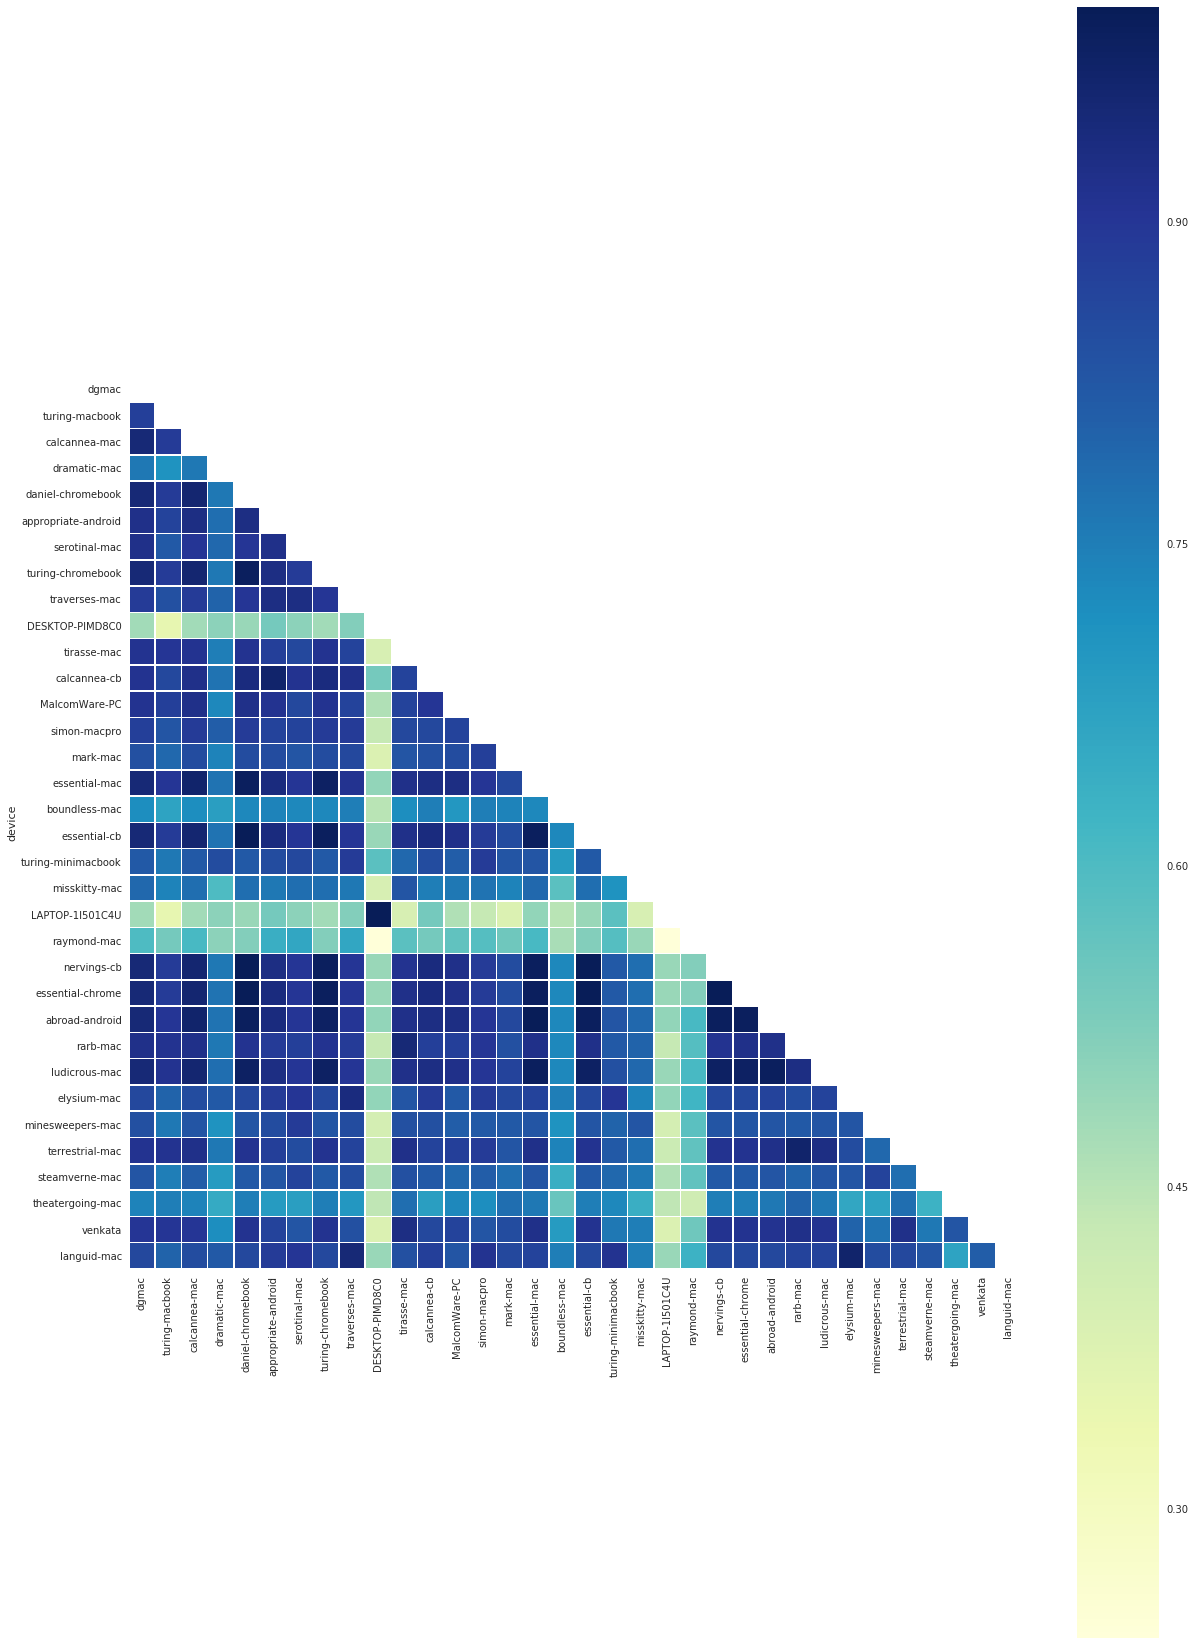

In [20]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()